In [1]:
import PyPDF2
import warnings
import textract 
from autocorrect import Speller
from nltk.tokenize import word_tokenize
import nltk
import re
import string
from nltk.corpus import stopwords, brown
from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from autocorrect import spell
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
filename = 'aakriti_aadhar.pdf'
open_filename = open(filename, 'rb')

ind_manifesto = PyPDF2.PdfFileReader(open_filename)

In [3]:
ind_manifesto.getDocumentInfo()

{'/Creator': 'Adobe Scan for Android 20.12.09-regular',
 '/Producer': 'Adobe Scan for Android 20.12.09-regular'}

In [4]:
import os
 
file_size = os.path.getsize(filename)
print("File Size is :", file_size, "bytes")

File Size is : 425101 bytes


In [5]:
total_pages = ind_manifesto.numPages
total_pages

2

In [6]:
def isValid(total_pages):
    if total_pages > 3:
        print("invalid document")
    else:
        print("valid document")

In [7]:
isValid(total_pages)

valid document


In [8]:
count = 0
text  = ''

# Lets loop through, to read each page from the pdf file
while(count < total_pages):
    # Get the specified number of pages in the document
    mani_page  = ind_manifesto.getPage(count)
    # Process the next page
    count += 1
    # Extract the text from the page
    text += mani_page.extractText()

In [9]:
if text != '':
    text = text
else:
    textract.process(open_filename, method='tesseract', encoding='utf-8', langauge='eng' )    


In [10]:
def to_lower(text):
    spell  = Speller(lang='en')
    texts = spell(text)
    return ' '.join([w.lower() for w in word_tokenize(text)])

lower_case = to_lower(text)

print(lower_case)

governmentof india aakriti aggarwal t4 ffdob : 13/04/2000hfet female 3128 1900 6203 34t t-th 3teut t 3t9tt unique identificationauthorityof india aadhaar address : d/o : t4fr t , d/o deepak kumar jindal , e6 sector 03 , ansal shushant city , ansal -6 hrr 03 , 3ht sttít shushant citly , meerut meerut utar pradesh-250103te , 34 tat r , r5 , hte , 3 tt-2501033128 1900 6203 aadhaar-aamadmi ka adhikar


In [11]:
def clean_text(lower_case):
    # split text phrases into words
    words  = nltk.word_tokenize(lower_case)
    
    
    # Create a list of all the punctuations we wish to remove
    punctuations = ['.', ',', '/', '!', '?', ';', ':', '(',')', '[',']', '-', '_', '%']
    
    # Remove all the special characters
    punctuations = re.sub(r'\W', ' ', str(lower_case))
    
    # Initialize the stopwords variable, which is a list of words ('and', 'the', 'i', 'yourself', 'is') that do not hold much values as key words
    stop_words  = stopwords.words('english')
    
    # Getting rid of all the words that contain numbers in them
    w_num = re.sub('\w*\d\w*', '', lower_case).strip()
    
    # remove all single characters
    lower_case = re.sub(r'\s+[a-zA-Z]\s+', ' ', lower_case)
    
    # Substituting multiple spaces with single space
    lower_case = re.sub(r'\s+', ' ', lower_case, flags=re.I)
    
    # Removing prefixed 'b'
    lower_case = re.sub(r'^b\s+', '', lower_case)
    
    
    
    # Removing non-english characters
    lower_case = re.sub(r'^b\s+', '', lower_case)
    
    # Return keywords which are not in stop words 
    keywords = [word for word in words if not word in stop_words  and word in punctuations and  word in w_num]
    
    return keywords

In [12]:
# Lemmatize the words
wordnet_lemmatizer = WordNetLemmatizer()

lemmatized_word = [wordnet_lemmatizer.lemmatize(word) for word in clean_text(lower_case)]

# lets print out the output from our function above and see how the data looks like
clean_data = ' '.join(lemmatized_word)
print(clean_data)

governmentof india aakriti aggarwal ffdob female unique identificationauthorityof india aadhaar address deepak kumar jindal sector ansal shushant city ansal hrr sttít shushant citly meerut meerut utar tat r hte ka adhikar


In [13]:
import pandas as pd

In [14]:
df = pd.read_csv('document.csv')

In [15]:
df.head()

,document,Class
0,Aadhar Card,Government India Name DOB Gender Aadhar Address
1,Pan Card,IncomeTax Department India Permanent Account N...
2,Resume,Organize Information Technology Project Work
3,Passport,Issue Authority Date Nationality Name Expiry P...
4,Certificate,Board Secondary Education Senior School India ...


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   document  99 non-null     object
 1   Class     99 non-null     object
dtypes: object(2)
memory usage: 1.7+ KB


In [17]:
df.columns

Index(['document', 'Class'], dtype='object')

In [18]:
df['category_id'] = df['document'].factorize()[0]
from io import StringIO
category_id_df = df[['document', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'document']].values)

In [19]:
df.head()

,document,Class,category_id
0,Aadhar Card,Government India Name DOB Gender Aadhar Address,0
1,Pan Card,IncomeTax Department India Permanent Account N...,1
2,Resume,Organize Information Technology Project Work,2
3,Passport,Issue Authority Date Nationality Name Expiry P...,3
4,Certificate,Board Secondary Education Senior School India ...,4


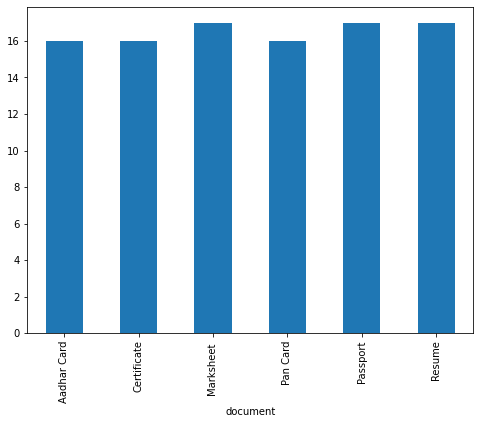

In [20]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('document').Class.count().plot.bar(ylim=0)
plt.show()

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.Class).toarray()
labels = df.category_id
features.shape

(99, 91)

In [22]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# 'Aadhar Card':
  . Most correlated unigrams:
       . gender
       . aadhar
  . Most correlated bigrams:
       . gender aadhar
       . india dob
# 'Certificate':
  . Most correlated unigrams:
       . roll
       . english
  . Most correlated bigrams:
       . english board
       . roll english
# 'Marksheet ':
  . Most correlated unigrams:
       . admission
       . grade
  . Most correlated bigrams:
       . examination grade
       . grade mother
# 'Pan Card':
  . Most correlated unigrams:
       . number
       . card
  . Most correlated bigrams:
       . father date
       . permanent account
# 'Passport':
  . Most correlated unigrams:
       . passport
       . nationality
  . Most correlated bigrams:
       . date nationality
       . issue authority
# 'Resume':
  . Most correlated unigrams:
       . responsibility
       . cgpa
  . Most correlated bigrams:
       . information technology
       . cgpa responsibility


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['Class'], df['document'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [24]:
print(clf.predict(count_vect.transform([clean_data])))

['Aadhar Card']
